# Lecture 9: Copula Fitting — Kendall's Tau & Gaussian Copula

This notebook covers:
1. **Simulating Kendall's tau** and its relationship to copula parameters
2. **Fitting a Gaussian copula** to data via the pseudo-sample MLE algorithm (Lecture 9 handout)
3. **Sample data generation** with a known dependence structure for validation

References: McNeil, Frey & Embrechts — *Quantitative Risk Management*, Chapter 7

---
## 0. Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.stats import norm, t as t_dist, kendalltau
from scipy.optimize import brentq
from itertools import combinations

np.random.seed(42)
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})

---
## 1. Sample Data Generation with Known Dependence

We simulate bivariate data from a **Gaussian copula** with known $\rho$, then impose
heavy-tailed marginals (Student-t) to mimic equity return series.

The procedure:
1. Draw $(Z_1, Z_2) \sim \mathcal{N}(0, \Sigma)$ with $\Sigma_{12} = \rho$
2. Apply $U_i = \Phi(Z_i)$ to get uniform marginals on $[0,1]$
3. Apply $X_i = F_i^{-1}(U_i)$ with $F_i = t_{\nu_i}(\mu_i, \sigma_i)$

**True parameters:** $\rho = 0.60$, $\nu_1 = 5$ (S&P500-like), $\nu_2 = 6$ (FTSE-like), $n = 500$

In [3]:
# ─── True parameters ──────────────────────────────────────────────────────────
RHO_TRUE   = 0.60       # true Gaussian copula correlation
NU1, NU2   = 5.0, 6.0   # degrees of freedom for marginals
MU1, SIG1  = 0.10, 0.73  # location/scale for series 1 (S&P500-like)
MU2, SIG2  = 0.03, 0.74  # location/scale for series 2 (FTSE-like)
N          = 500         # number of observations

def simulate_gaussian_copula_data(rho, nu1, nu2, mu1, sig1, mu2, sig2, n, seed=42):
    """
    Simulate bivariate data from a Gaussian copula with Student-t marginals.
    
    Parameters
    ----------
    rho            : true copula correlation
    nu1, nu2       : degrees of freedom for t marginals
    mu1/sig1       : location/scale for marginal 1
    mu2/sig2       : location/scale for marginal 2
    n              : sample size
    
    Returns
    -------
    X1, X2         : observed data arrays
    U1, U2         : true uniform scores (oracle, for comparison only)
    """
    rng = np.random.default_rng(seed)
    
    # Step 1: draw from bivariate normal with correlation rho
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])
    Z = rng.multivariate_normal(mean=[0, 0], cov=Sigma, size=n)  # (n, 2)
    
    # Step 2: map to uniform via standard normal CDF → U_i = Phi(Z_i)
    U1_true = norm.cdf(Z[:, 0])
    U2_true = norm.cdf(Z[:, 1])
    
    # Step 3: map to t marginals via quantile transform
    X1 = t_dist.ppf(U1_true, df=nu1, loc=mu1, scale=sig1)
    X2 = t_dist.ppf(U2_true, df=nu2, loc=mu2, scale=sig2)
    
    return X1, X2, U1_true, U2_true


X1, X2, U1_true, U2_true = simulate_gaussian_copula_data(
    RHO_TRUE, NU1, NU2, MU1, SIG1, MU2, SIG2, N
)

print(f"Sample size : {N}")
print(f"True rho    : {RHO_TRUE}")
print(f"X1 — mean: {X1.mean():.4f}, std: {X1.std():.4f}")
print(f"X2 — mean: {X2.mean():.4f}, std: {X2.std():.4f}")

Sample size : 500
True rho    : 0.6
X1 — mean: 0.1347, std: 1.0119
X2 — mean: 0.0217, std: 0.8193


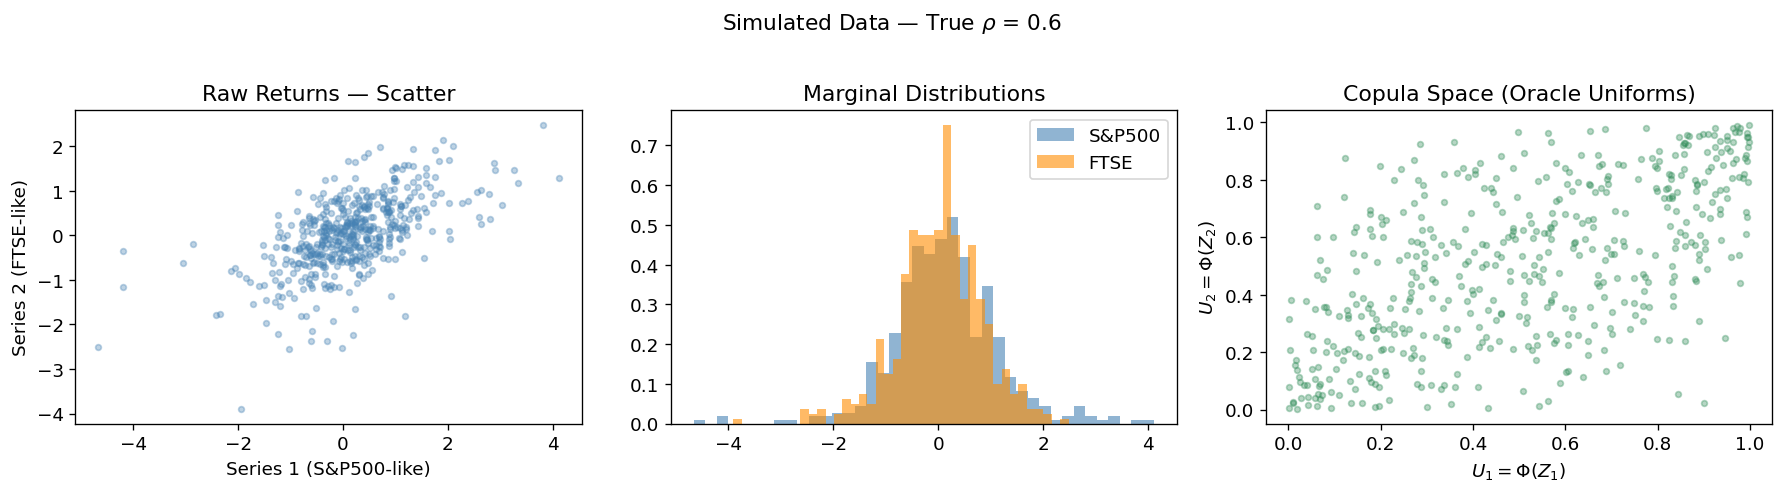

In [4]:
# ─── Visualise the raw data ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Scatter of raw returns
axes[0].scatter(X1, X2, alpha=0.35, s=12, color='steelblue')
axes[0].set_xlabel('Series 1 (S&P500-like)')
axes[0].set_ylabel('Series 2 (FTSE-like)')
axes[0].set_title('Raw Returns — Scatter')

# Marginal distributions
axes[1].hist(X1, bins=40, alpha=0.6, label='S&P500', color='steelblue', density=True)
axes[1].hist(X2, bins=40, alpha=0.6, label='FTSE',   color='darkorange', density=True)
axes[1].set_title('Marginal Distributions')
axes[1].legend()

# Scatter in uniform (oracle) space
axes[2].scatter(U1_true, U2_true, alpha=0.35, s=12, color='seagreen')
axes[2].set_xlabel('$U_1 = \\Phi(Z_1)$')
axes[2].set_ylabel('$U_2 = \\Phi(Z_2)$')
axes[2].set_title('Copula Space (Oracle Uniforms)')

plt.suptitle(f'Simulated Data — True $\\rho$ = {RHO_TRUE}', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 2. Kendall's Tau: Theory, Simulation, and Estimation

### 2.1 Theoretical Relationship

For a **Gaussian copula** with parameter $\rho$:
$$\tau = \frac{2}{\pi} \arcsin(\rho)$$

Inverted to recover $\rho$ from $\tau$:
$$\rho = \sin\!\left(\frac{\pi}{2}\tau\right)$$

For **Archimedean copulas** (from lecture):
- Gumbel: $\tau = 1 - 1/\theta$
- Clayton: $\tau = \theta/(\theta + 2)$

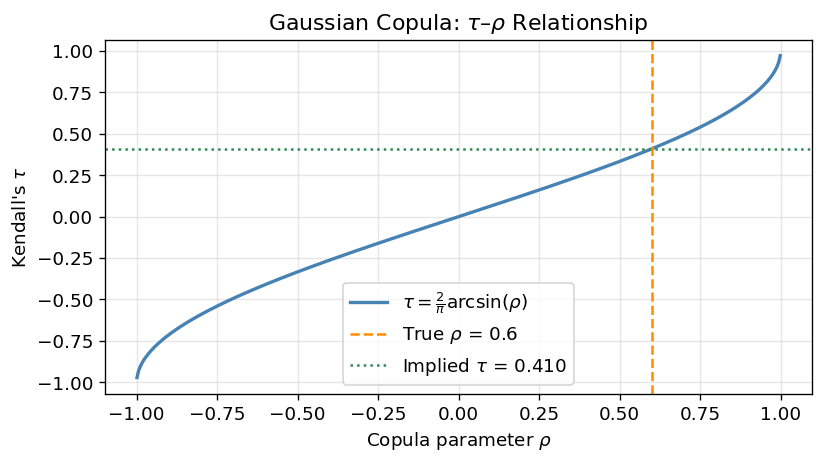

True rho = 0.6  →  Implied tau = 0.4097


In [5]:
# ─── Theoretical tau-rho relationship for Gaussian copula ─────────────────────
rho_grid = np.linspace(-0.999, 0.999, 400)
tau_grid  = (2 / np.pi) * np.arcsin(rho_grid)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(rho_grid, tau_grid, color='steelblue', linewidth=2, label="$\\tau = \\frac{2}{\\pi}\\arcsin(\\rho)$")
ax.axvline(RHO_TRUE, color='darkorange', linestyle='--', label=f'True $\\rho$ = {RHO_TRUE}')
ax.axhline((2/np.pi)*np.arcsin(RHO_TRUE), color='seagreen', linestyle=':', 
           label=f'Implied $\\tau$ = {(2/np.pi)*np.arcsin(RHO_TRUE):.3f}')
ax.set_xlabel('Copula parameter $\\rho$')
ax.set_ylabel("Kendall's $\\tau$")
ax.set_title("Gaussian Copula: $\\tau$–$\\rho$ Relationship")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tau_implied = (2 / np.pi) * np.arcsin(RHO_TRUE)
print(f"True rho = {RHO_TRUE}  →  Implied tau = {tau_implied:.4f}")

### 2.2 Sample Kendall's Tau — Definition and Computation

Given $n$ observations $(X_{1i}, X_{2i})$, the **sample Kendall's tau** is:

$$\hat{\tau} = \frac{\text{(concordant pairs)} - \text{(discordant pairs)}}{\binom{n}{2}}$$

A pair $(i, j)$ is **concordant** if $(X_{1i}-X_{1j})(X_{2i}-X_{2j}) > 0$, **discordant** if $< 0$.

In [6]:
# ─── Manual Kendall's tau implementation ──────────────────────────────────────
def kendall_tau_manual(x1, x2):
    """
    Compute Kendall's tau directly from the definition.
    O(n^2) — fine for n ≤ 1000.
    """
    n = len(x1)
    concordant = 0
    discordant = 0
    
    for i, j in combinations(range(n), 2):
        sign1 = np.sign(x1[i] - x1[j])
        sign2 = np.sign(x2[i] - x2[j])
        product = sign1 * sign2
        if product > 0:
            concordant += 1
        elif product < 0:
            discordant += 1
        # ties (product == 0) are ignored
    
    n_pairs = n * (n - 1) / 2
    return (concordant - discordant) / n_pairs


# Efficient version using scipy (equivalent, much faster)
def kendall_tau_scipy(x1, x2):
    tau, pval = kendalltau(x1, x2)
    return tau, pval


# Use scipy on full data; manual on a subsample for demonstration
tau_hat_scipy, pval = kendall_tau_scipy(X1, X2)
tau_hat_manual = kendall_tau_manual(X1[:150], X2[:150])  # subsample for speed

print(f"Implied tau (true rho={RHO_TRUE}) : {tau_implied:.4f}")
print(f"Estimated tau (scipy, n={N})       : {tau_hat_scipy:.4f}  (p-value: {pval:.2e})")
print(f"Estimated tau (manual, n=150)      : {tau_hat_manual:.4f}")

Implied tau (true rho=0.6) : 0.4097
Estimated tau (scipy, n=500)       : 0.4156  (p-value: 7.18e-44)
Estimated tau (manual, n=150)      : 0.4545


### 2.3 Simulation Study: Convergence of $\hat{\tau}$ to $\tau$

We simulate many samples from the same Gaussian copula and track how $\hat{\tau}$ converges as $n$ grows.

C:\Users\athay\AppData\Local\Temp\ipykernel_31868\4152220351.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(


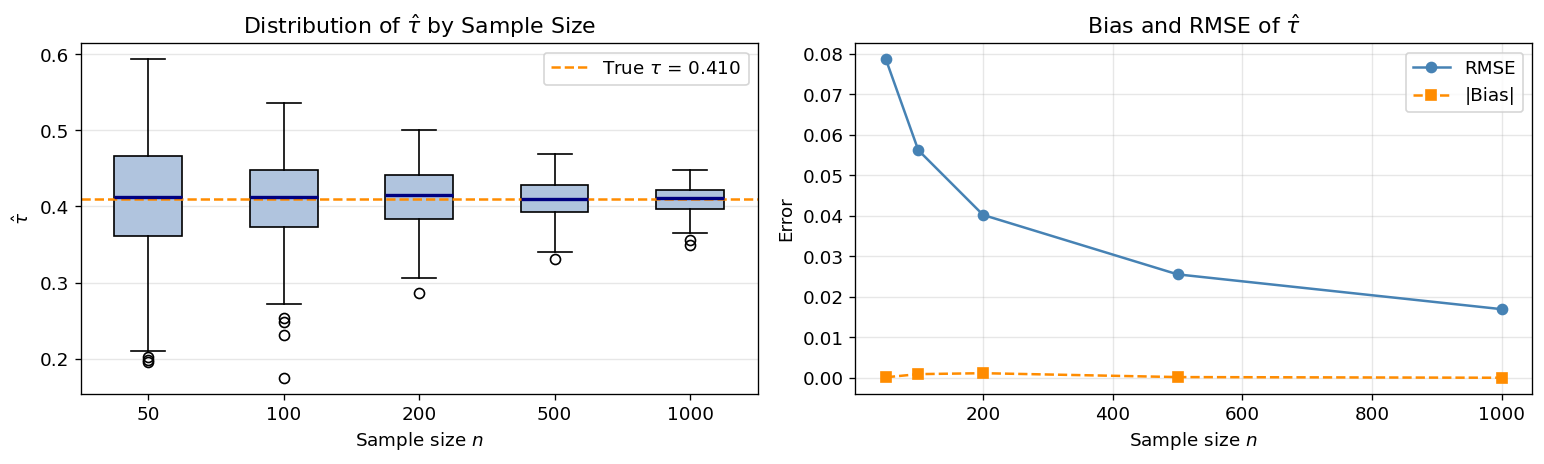


     n |  mean(tau_hat) |     bias |     RMSE
---------------------------------------------
    50 |         0.4098 |   0.0002 |   0.0787
   100 |         0.4106 |   0.0010 |   0.0562
   200 |         0.4108 |   0.0012 |   0.0402
   500 |         0.4094 |  -0.0002 |   0.0256
  1000 |         0.4096 |  -0.0001 |   0.0170


In [7]:
# ─── Convergence simulation ────────────────────────────────────────────────────
def draw_tau_estimates(rho, sample_sizes, n_reps=200, seed=0):
    """
    For each sample size in sample_sizes, simulate n_reps datasets
    from a Gaussian copula with parameter rho, and compute tau_hat each time.
    """
    rng  = np.random.default_rng(seed)
    Sigma = np.array([[1, rho], [rho, 1]])
    results = {}   # dict: n → array of tau_hat
    
    for n in sample_sizes:
        taus = []
        for _ in range(n_reps):
            Z  = rng.multivariate_normal([0, 0], Sigma, size=n)
            tau_hat, _ = kendalltau(Z[:, 0], Z[:, 1])
            taus.append(tau_hat)
        results[n] = np.array(taus)
    
    return results


sample_sizes = [50, 100, 200, 500, 1000]
sim_results  = draw_tau_estimates(RHO_TRUE, sample_sizes, n_reps=300)
tau_true     = (2 / np.pi) * np.arcsin(RHO_TRUE)

# ─── Plot: boxplots of tau_hat by sample size ──────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Boxplot
axes[0].boxplot(
    [sim_results[n] for n in sample_sizes],
    labels=sample_sizes,
    patch_artist=True,
    boxprops=dict(facecolor='lightsteelblue'),
    medianprops=dict(color='navy', linewidth=2)
)
axes[0].axhline(tau_true, color='darkorange', linestyle='--', linewidth=1.5,
                label=f'True $\\tau$ = {tau_true:.3f}')
axes[0].set_xlabel('Sample size $n$')
axes[0].set_ylabel("$\\hat{\\tau}$")
axes[0].set_title("Distribution of $\\hat{\\tau}$ by Sample Size")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Bias and RMSE
bias  = [sim_results[n].mean() - tau_true     for n in sample_sizes]
rmse  = [np.sqrt(((sim_results[n] - tau_true)**2).mean()) for n in sample_sizes]

ax2 = axes[1]
ax2.plot(sample_sizes, rmse, 'o-', color='steelblue', label='RMSE')
ax2.plot(sample_sizes, np.abs(bias), 's--', color='darkorange', label='|Bias|')
ax2.set_xlabel('Sample size $n$')
ax2.set_ylabel('Error')
ax2.set_title("Bias and RMSE of $\\hat{\\tau}$")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'n':>6} | {'mean(tau_hat)':>14} | {'bias':>8} | {'RMSE':>8}")
print("-" * 45)
for n in sample_sizes:
    mu  = sim_results[n].mean()
    b   = mu - tau_true
    r   = np.sqrt(((sim_results[n] - tau_true)**2).mean())
    print(f"{n:>6} | {mu:>14.4f} | {b:>8.4f} | {r:>8.4f}")

---
## 3. Method-of-Moments: Back out $\rho$ from $\hat{\tau}$

From $\hat{\tau}$, recover the Gaussian copula parameter via:
$$\hat{\rho}^{\tau} = \sin\!\left(\frac{\pi}{2}\hat{\tau}\right)$$

Alternatively, using Spearman's $\rho_S$:
$$\hat{\rho}^{S} = 2\sin\!\left(\frac{\pi}{6}\hat{\rho}_S\right)$$

In [8]:
# ─── Method-of-moments estimators ─────────────────────────────────────────────
def rho_from_tau(tau_hat):
    """Gaussian copula rho from Kendall's tau (Prop 7.42 in MFE)."""
    return np.sin(np.pi / 2 * tau_hat)

def rho_from_spearman(rho_s_hat):
    """Gaussian copula rho from Spearman's rho."""
    return 2 * np.sin(np.pi / 6 * rho_s_hat)


# Compute empirical Kendall's tau and Spearman's rho on our dataset
tau_hat, _  = kendalltau(X1, X2)
rho_s_hat, _ = stats.spearmanr(X1, X2)

rho_mom_tau      = rho_from_tau(tau_hat)
rho_mom_spearman = rho_from_spearman(rho_s_hat)

print("Method-of-Moments Estimation")
print("=" * 40)
print(f"True rho                          : {RHO_TRUE:.4f}")
print()
print(f"Kendall's tau (empirical)         : {tau_hat:.4f}")
print(f"  → rho_hat (via tau)             : {rho_mom_tau:.4f}")
print()
print(f"Spearman's rho (empirical)        : {rho_s_hat:.4f}")
print(f"  → rho_hat (via Spearman)        : {rho_mom_spearman:.4f}")

Method-of-Moments Estimation
True rho                          : 0.6000

Kendall's tau (empirical)         : 0.4156
  → rho_hat (via tau)             : 0.6074

Spearman's rho (empirical)        : 0.5861
  → rho_hat (via Spearman)        : 0.6042


---
## 4. Algorithm: Fitting the Gaussian Copula via MLE

From the handout, the 3-step algorithm:

**Step 1.** Transform marginals to pseudo-uniforms using empirical ranks:
$$\hat{U}_{it} = \frac{\text{rank}(X_{it})}{n+1}$$

**Step 2.** Transform to standard normal:
$$Y_{it} = \Phi^{-1}(\hat{U}_{it})$$

**Step 3.** MLE on the resulting bivariate normal — which has the closed-form solution:
$$\hat{\rho} = \frac{1}{n} \sum_{t=1}^{n} Y_{1t} Y_{2t}$$

> **Why is this MLE and not just sample correlation?** Because we know the marginals are standard normal after step 2, so $\text{Var}(Y_{it}) = 1$ by construction. The sample correlation simplifies to the dot product above.

In [9]:
# ─── Gaussian copula fitting algorithm (Lecture 9, p.15) ──────────────────────

def fit_gaussian_copula_mle(x1, x2, verbose=True):
    """
    Fit a Gaussian copula to bivariate data via pseudo-MLE.
    
    Steps
    -----
    1. Rank-transform to pseudo-uniforms: U_hat = rank / (n+1)
    2. Apply inverse normal CDF: Y = Phi^{-1}(U_hat)
    3. MLE for bivariate normal with unit variances: rho_hat = (1/n) sum(Y1 * Y2)
    
    Returns
    -------
    rho_hat   : float, estimated Gaussian copula parameter
    U_hat     : (n, 2) pseudo-uniform sample
    Y         : (n, 2) normal scores
    log_lik   : float, log-likelihood at rho_hat
    """
    n = len(x1)
    assert len(x2) == n, "x1 and x2 must have equal length"
    
    # ── Step 1: Pseudo-uniform marginals ─────────────────────────────────────
    rank1 = stats.rankdata(x1)   # ties method: 'average' by default
    rank2 = stats.rankdata(x2)
    U1_hat = rank1 / (n + 1)
    U2_hat = rank2 / (n + 1)
    
    if verbose:
        print("Step 1 — Pseudo-uniform marginals")
        print(f"  U1_hat range: [{U1_hat.min():.4f}, {U1_hat.max():.4f}]")
        print(f"  U2_hat range: [{U2_hat.min():.4f}, {U2_hat.max():.4f}]")
    
    # ── Step 2: Transform to standard normal ─────────────────────────────────
    Y1 = norm.ppf(U1_hat)
    Y2 = norm.ppf(U2_hat)
    
    if verbose:
        print("\nStep 2 — Normal scores")
        print(f"  Y1: mean={Y1.mean():.4f}, std={Y1.std():.4f}  (should be ~0, ~1)")
        print(f"  Y2: mean={Y2.mean():.4f}, std={Y2.std():.4f}")
    
    # ── Step 3: MLE for bivariate normal with Var=1 ───────────────────────────
    # Log-likelihood: l(rho) = -n/2 * log(1-rho^2)
    #                         - 1/(2(1-rho^2)) * sum(y1^2 - 2*rho*y1*y2 + y2^2)
    #                         + 1/2 * sum(y1^2 + y2^2)   [constant wrt rho]
    # Closed-form MLE solution:
    rho_hat = (1 / n) * np.sum(Y1 * Y2)
    # Note: this is the sample correlation because Var(Y) = 1 by construction
    
    if verbose:
        print(f"\nStep 3 — MLE")
        print(f"  rho_hat = (1/n) * sum(Y1 * Y2) = {rho_hat:.4f}")
    
    # ── Evaluate log-likelihood at rho_hat ────────────────────────────────────
    log_lik = gaussian_copula_loglik(Y1, Y2, rho_hat)
    
    U_hat = np.column_stack([U1_hat, U2_hat])
    Y     = np.column_stack([Y1, Y2])
    
    return rho_hat, U_hat, Y, log_lik


def gaussian_copula_loglik(Y1, Y2, rho):
    """
    Log-likelihood of Gaussian copula for normal scores Y1, Y2.
    
    l(rho) = -n/2 * log(1-rho^2) 
             - rho/(2*(1-rho^2)) * sum(2*y1*y2 - rho*(y1^2 + y2^2))
    """
    n   = len(Y1)
    if abs(rho) >= 1:
        return -np.inf
    d   = 1 - rho**2
    ll  = (-n / 2) * np.log(d)
    ll -= (1 / (2 * d)) * np.sum(Y1**2 - 2 * rho * Y1 * Y2 + Y2**2)
    ll += (1 / 2) * np.sum(Y1**2 + Y2**2)   # add back the constant part
    return ll


# ─── Fit on our simulated data ─────────────────────────────────────────────────
rho_mle, U_hat, Y_scores, ll = fit_gaussian_copula_mle(X1, X2, verbose=True)

print(f"\n{'='*45}")
print(f"True rho          : {RHO_TRUE:.4f}")
print(f"MLE estimate      : {rho_mle:.4f}")
print(f"MoM (tau-based)   : {rho_mom_tau:.4f}")
print(f"Log-likelihood    : {ll:.2f}")

Step 1 — Pseudo-uniform marginals
  U1_hat range: [0.0020, 0.9980]
  U2_hat range: [0.0020, 0.9980]

Step 2 — Normal scores
  Y1: mean=-0.0000, std=0.9893  (should be ~0, ~1)
  Y2: mean=-0.0000, std=0.9893

Step 3 — MLE
  rho_hat = (1/n) * sum(Y1 * Y2) = 0.5962

True rho          : 0.6000
MLE estimate      : 0.5962
MoM (tau-based)   : 0.6074
Log-likelihood    : 115.67


### 4.1 Log-Likelihood Profile

Visualise $\ell(\rho)$ as a function of $\rho$ to confirm the MLE is at the maximum.

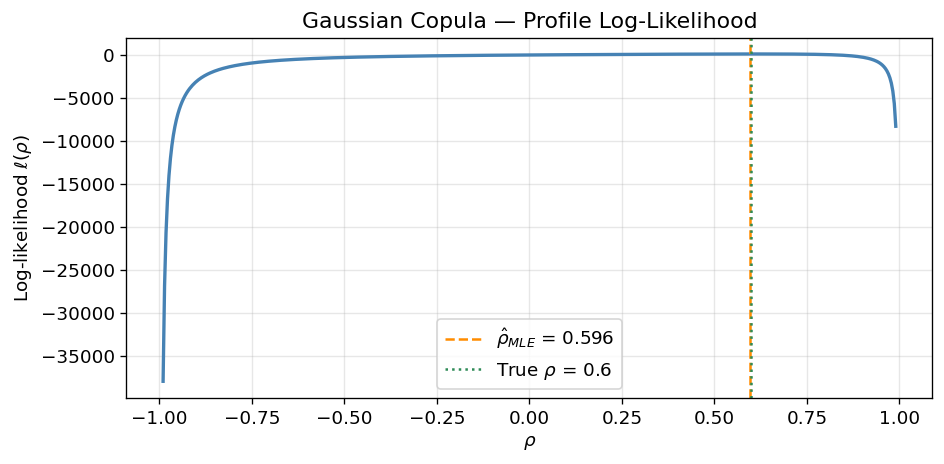

In [10]:
# ─── Profile log-likelihood ────────────────────────────────────────────────────
Y1_scores = Y_scores[:, 0]
Y2_scores = Y_scores[:, 1]

rho_vals = np.linspace(-0.99, 0.99, 500)
ll_vals  = [gaussian_copula_loglik(Y1_scores, Y2_scores, r) for r in rho_vals]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(rho_vals, ll_vals, color='steelblue', linewidth=2)
ax.axvline(rho_mle,   color='darkorange', linestyle='--', linewidth=1.5,
           label=f'$\\hat{{\\rho}}_{{MLE}}$ = {rho_mle:.3f}')
ax.axvline(RHO_TRUE,  color='seagreen',   linestyle=':',  linewidth=1.5,
           label=f'True $\\rho$ = {RHO_TRUE}')
ax.set_xlabel('$\\rho$')
ax.set_ylabel('Log-likelihood $\\ell(\\rho)$')
ax.set_title('Gaussian Copula — Profile Log-Likelihood')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Visualise the Pseudo-Sample

Inspect each step of the algorithm: raw data → uniform scores → normal scores.

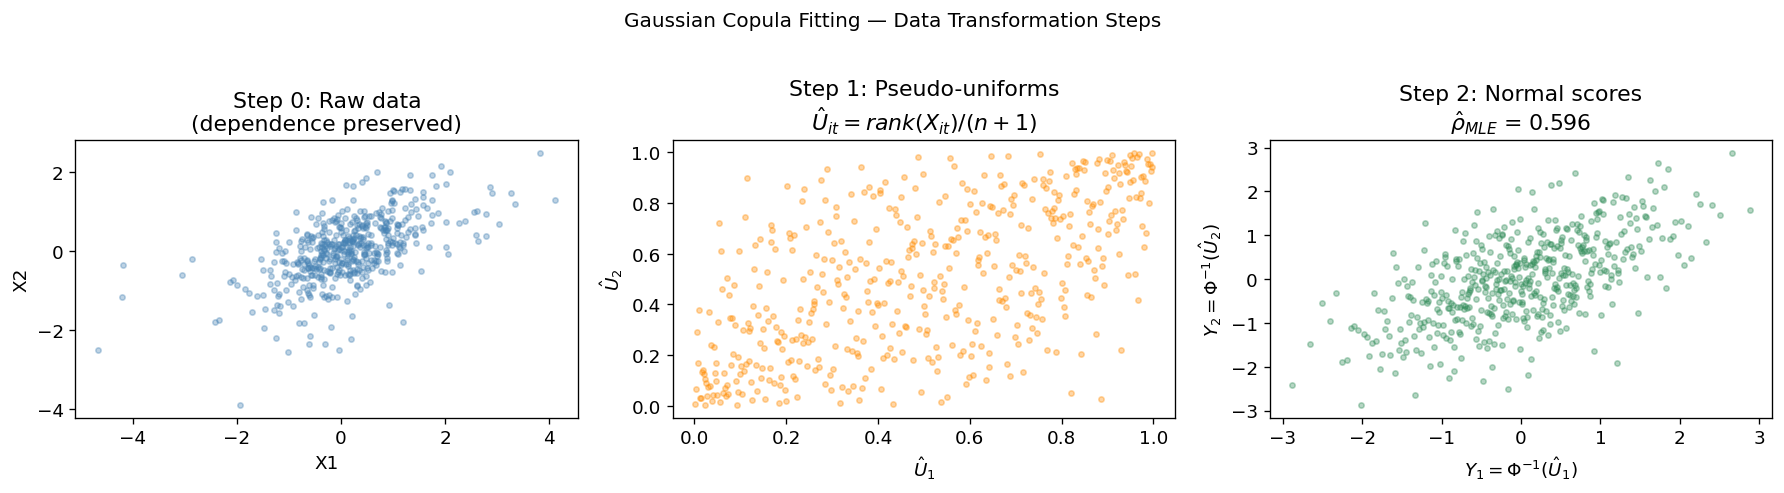

In [11]:
# ─── Step-by-step transformation visualisation ────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(X1, X2, alpha=0.35, s=10, color='steelblue')
axes[0].set_title(f'Step 0: Raw data\n(dependence preserved)')
axes[0].set_xlabel('X1'); axes[0].set_ylabel('X2')

axes[1].scatter(U_hat[:, 0], U_hat[:, 1], alpha=0.35, s=10, color='darkorange')
axes[1].set_title('Step 1: Pseudo-uniforms\n$\\hat{U}_{it} = rank(X_{it})/(n+1)$')
axes[1].set_xlabel('$\\hat{U}_1$'); axes[1].set_ylabel('$\\hat{U}_2$')

axes[2].scatter(Y_scores[:, 0], Y_scores[:, 1], alpha=0.35, s=10, color='seagreen')
axes[2].set_title(f'Step 2: Normal scores\n$\\hat{{\\rho}}_{{MLE}}$ = {rho_mle:.3f}')
axes[2].set_xlabel('$Y_1 = \\Phi^{{-1}}(\\hat{{U}}_1)$')
axes[2].set_ylabel('$Y_2 = \\Phi^{{-1}}(\\hat{{U}}_2)$')

plt.suptitle('Gaussian Copula Fitting — Data Transformation Steps', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

---
## 5. Comparison: MoM vs MLE across Different $\rho$ Values

Simulate 200 datasets for each true $\rho \in \{0.2, 0.4, 0.6, 0.8\}$ and compare the
two estimators.

In [12]:
# ─── Simulation study: MoM vs MLE ─────────────────────────────────────────────
def run_comparison(rho_true_values, n=300, n_reps=200, seed=99):
    """
    For each rho in rho_true_values, simulate n_reps datasets and
    compare MoM (Kendall's tau) and MLE estimators.
    """
    rng = np.random.default_rng(seed)
    rows = []
    
    for rho_true in rho_true_values:
        Sigma = np.array([[1, rho_true], [rho_true, 1]])
        tau_true = (2 / np.pi) * np.arcsin(rho_true)
        
        for _ in range(n_reps):
            Z = rng.multivariate_normal([0, 0], Sigma, size=n)
            
            # MoM
            tau_hat, _ = kendalltau(Z[:, 0], Z[:, 1])
            rho_mom = rho_from_tau(tau_hat)
            
            # MLE (same data — Z is already standard normal, so steps 1&2 are exact)
            rho_mle_rep, _, _, _ = fit_gaussian_copula_mle(Z[:, 0], Z[:, 1], verbose=False)
            
            rows.append({'rho_true': rho_true, 'rho_mom': rho_mom, 'rho_mle': rho_mle_rep})
    
    return pd.DataFrame(rows)


rho_vals_study = [0.2, 0.4, 0.6, 0.8]
df_comp = run_comparison(rho_vals_study, n=300, n_reps=200)

# ─── Summary statistics ────────────────────────────────────────────────────────
summary = df_comp.groupby('rho_true').agg(
    mom_mean=('rho_mom', 'mean'),
    mom_std= ('rho_mom', 'std'),
    mle_mean=('rho_mle', 'mean'),
    mle_std= ('rho_mle', 'std')
).reset_index()
summary['mom_bias'] = summary['mom_mean'] - summary['rho_true']
summary['mle_bias'] = summary['mle_mean'] - summary['rho_true']

print("Comparison: Method-of-Moments vs MLE  (n=300, 200 reps)")
print(summary.to_string(index=False, float_format='{:.4f}'.format))

Comparison: Method-of-Moments vs MLE  (n=300, 200 reps)
 rho_true  mom_mean  mom_std  mle_mean  mle_std  mom_bias  mle_bias
   0.2000    0.2031   0.0562    0.1956   0.0524    0.0031   -0.0044
   0.4000    0.4012   0.0515    0.3851   0.0488    0.0012   -0.0149
   0.6000    0.6025   0.0399    0.5808   0.0356    0.0025   -0.0192
   0.8000    0.8023   0.0219    0.7730   0.0200    0.0023   -0.0270


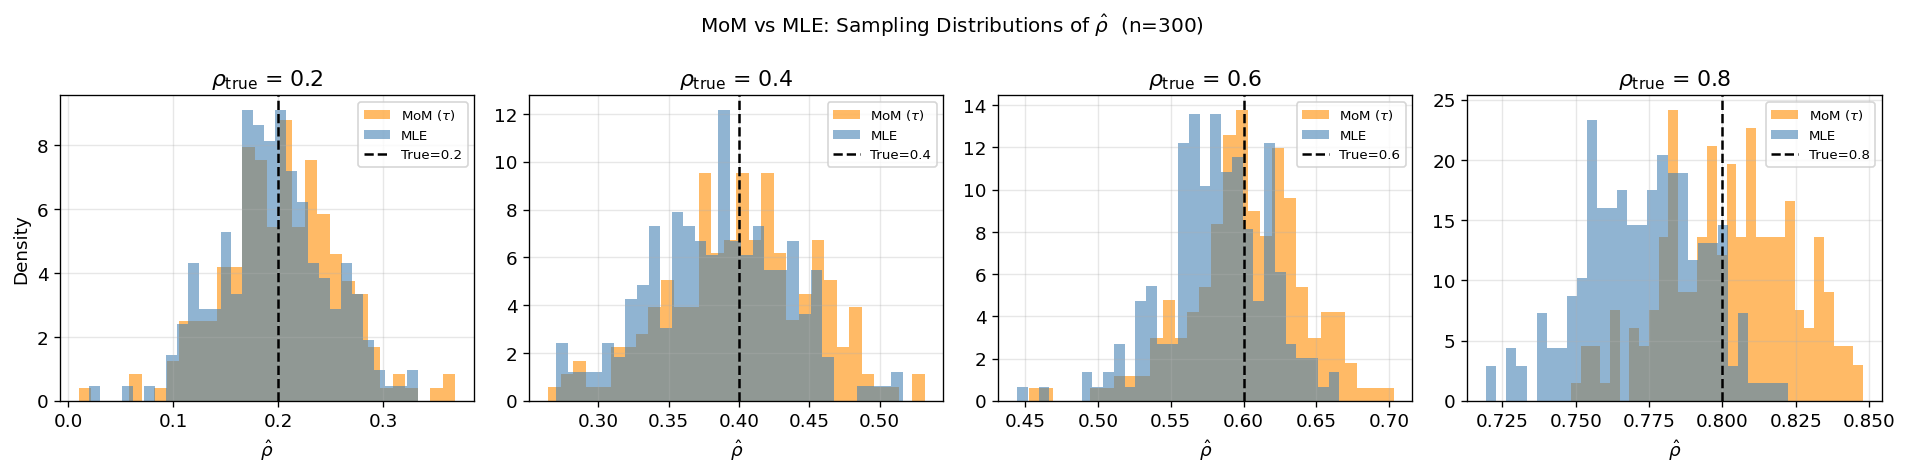

In [13]:
# ─── Visualise estimator distributions ────────────────────────────────────────
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=False)

for ax, rho_true in zip(axes, rho_vals_study):
    sub = df_comp[df_comp['rho_true'] == rho_true]
    ax.hist(sub['rho_mom'], bins=30, alpha=0.6, color='darkorange', label='MoM ($\\tau$)', density=True)
    ax.hist(sub['rho_mle'], bins=30, alpha=0.6, color='steelblue',  label='MLE',          density=True)
    ax.axvline(rho_true, color='black', linestyle='--', linewidth=1.5, label=f'True={rho_true}')
    ax.set_title(f'$\\rho_{{\\text{{true}}}}$ = {rho_true}')
    ax.set_xlabel('$\\hat{\\rho}$')
    if ax == axes[0]:
        ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('MoM vs MLE: Sampling Distributions of $\\hat{\\rho}$  (n=300)', fontsize=12)
plt.tight_layout()
plt.show()

---
## 6. Archimedean Copulas: Tau and Parameter Recovery

Quick comparison of Kendall's tau formulas for Gumbel and Clayton (from lecture).

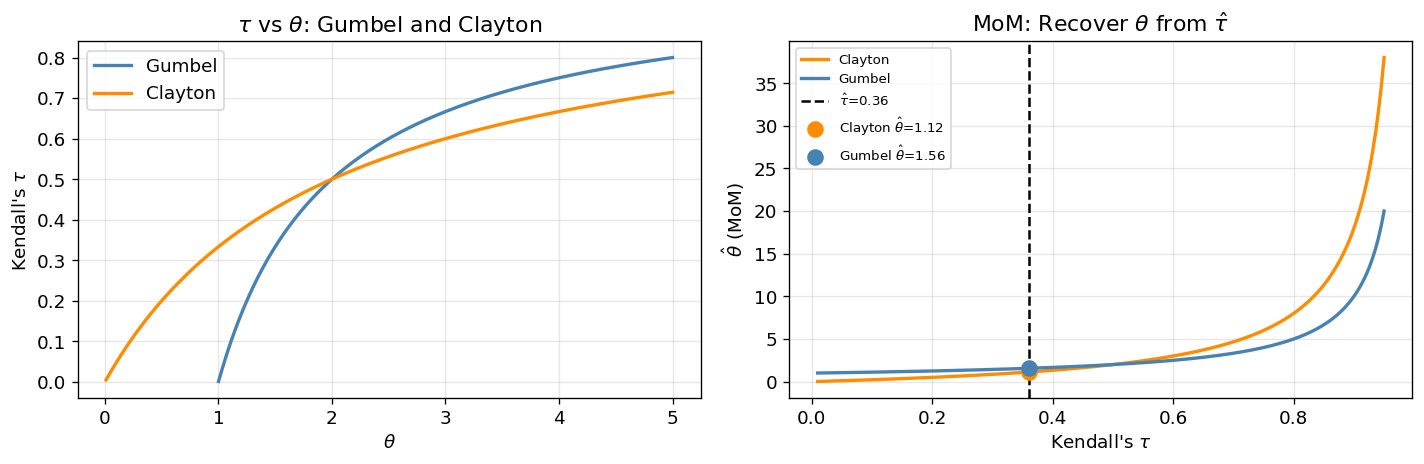

tau_hat = 0.36
  Clayton theta_hat = 1.1250  (lecture: 1.14)
  Gumbel  theta_hat = 1.5625


In [14]:
# ─── Archimedean tau formulas ──────────────────────────────────────────────────

def gumbel_tau(theta):
    """tau = 1 - 1/theta  (theta >= 1)"""
    return 1 - 1 / theta

def gumbel_theta(tau):
    """Invert: theta = 1/(1-tau)"""
    return 1 / (1 - tau)

def clayton_tau(theta):
    """tau = theta / (theta + 2)  (theta > 0)"""
    return theta / (theta + 2)

def clayton_theta(tau):
    """Invert: theta = 2*tau / (1-tau)"""
    return 2 * tau / (1 - tau)


# Plot tau vs theta for both
theta_vals = np.linspace(0.01, 5, 300)
theta_gumbel = np.linspace(1.001, 5, 300)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(theta_gumbel, gumbel_tau(theta_gumbel),  color='steelblue',  linewidth=2, label='Gumbel')
axes[0].plot(theta_vals,   clayton_tau(theta_vals),   color='darkorange', linewidth=2, label='Clayton')
axes[0].set_xlabel('$\\theta$')
axes[0].set_ylabel("Kendall's $\\tau$")
axes[0].set_title('$\\tau$ vs $\\theta$: Gumbel and Clayton')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Demonstrate parameter recovery on S&P/FTSE-like tau
tau_example = 0.36   # from lecture slide (empirical estimate)

theta_cl  = clayton_theta(tau_example)
theta_gu  = gumbel_theta(tau_example)
tau_vals  = np.linspace(0.01, 0.95, 200)

axes[1].plot(tau_vals, clayton_theta(tau_vals), color='darkorange', linewidth=2, label='Clayton')
axes[1].plot(tau_vals, gumbel_theta(tau_vals),  color='steelblue',  linewidth=2, label='Gumbel')
axes[1].axvline(tau_example, color='black', linestyle='--', linewidth=1.5, label=f'$\\hat\\tau$={tau_example}')
axes[1].scatter([tau_example], [theta_cl], color='darkorange', zorder=5, s=80,
                label=f'Clayton $\\hat\\theta$={theta_cl:.2f}')
axes[1].scatter([tau_example], [theta_gu], color='steelblue', zorder=5, s=80,
                label=f'Gumbel $\\hat\\theta$={theta_gu:.2f}')
axes[1].set_xlabel("Kendall's $\\tau$")
axes[1].set_ylabel('$\\hat{\\theta}$ (MoM)')
axes[1].set_title('MoM: Recover $\\theta$ from $\\hat{\\tau}$')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"tau_hat = {tau_example}")
print(f"  Clayton theta_hat = {theta_cl:.4f}  (lecture: 1.14)")
print(f"  Gumbel  theta_hat = {theta_gu:.4f}")

---
## 7. Summary Table

Collect all estimates on our simulated dataset.

In [15]:
# ─── Final summary ─────────────────────────────────────────────────────────────
tau_hat_final, _   = kendalltau(X1, X2)
rhos_hat_final, _  = stats.spearmanr(X1, X2)

rho_mom_tau_final      = rho_from_tau(tau_hat_final)
rho_mom_spearman_final = rho_from_spearman(rhos_hat_final)
rho_mle_final, _, _, ll_final = fit_gaussian_copula_mle(X1, X2, verbose=False)

print("="*55)
print("Summary: Gaussian Copula Estimation on Simulated Data")
print("="*55)
print(f"True parameter (rho)              : {RHO_TRUE:.4f}")
print(f"True Kendall's tau                : {(2/np.pi)*np.arcsin(RHO_TRUE):.4f}")
print()
print(f"Empirical Kendall's tau           : {tau_hat_final:.4f}")
print(f"Empirical Spearman's rho          : {rhos_hat_final:.4f}")
print()
print(f"rho_hat — MoM via tau             : {rho_mom_tau_final:.4f}")
print(f"rho_hat — MoM via Spearman        : {rho_mom_spearman_final:.4f}")
print(f"rho_hat — MLE (pseudo-sample)     : {rho_mle_final:.4f}")
print()
print(f"Log-likelihood at MLE             : {ll_final:.2f}")
print("="*55)

Summary: Gaussian Copula Estimation on Simulated Data
True parameter (rho)              : 0.6000
True Kendall's tau                : 0.4097

Empirical Kendall's tau           : 0.4156
Empirical Spearman's rho          : 0.5861

rho_hat — MoM via tau             : 0.6074
rho_hat — MoM via Spearman        : 0.6042
rho_hat — MLE (pseudo-sample)     : 0.5962

Log-likelihood at MLE             : 115.67
